In [1]:
%%capture
!pip install -Uq segmentation-models-pytorch

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm import tqdm  # Standard tqdm instead of tqdm.notebook
from pathlib import Path
import cv2 as cv
from PIL import Image
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
train_csv = Path('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train')
base_path = Path('/kaggle/input/nyu-depth-v2/nyu_data')
df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: base_path / x)
df[1] = df[1].map(lambda x: base_path / x)
train_df, val_df = train_test_split(df, test_size=0.1, shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(len(train_df), len(val_df), len(test_df))
train_df

45619 4562 507


,0,1
0,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
1,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
2,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
3,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
4,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
...,...,...
45614,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
45615,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
45616,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...
45617,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...,/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...


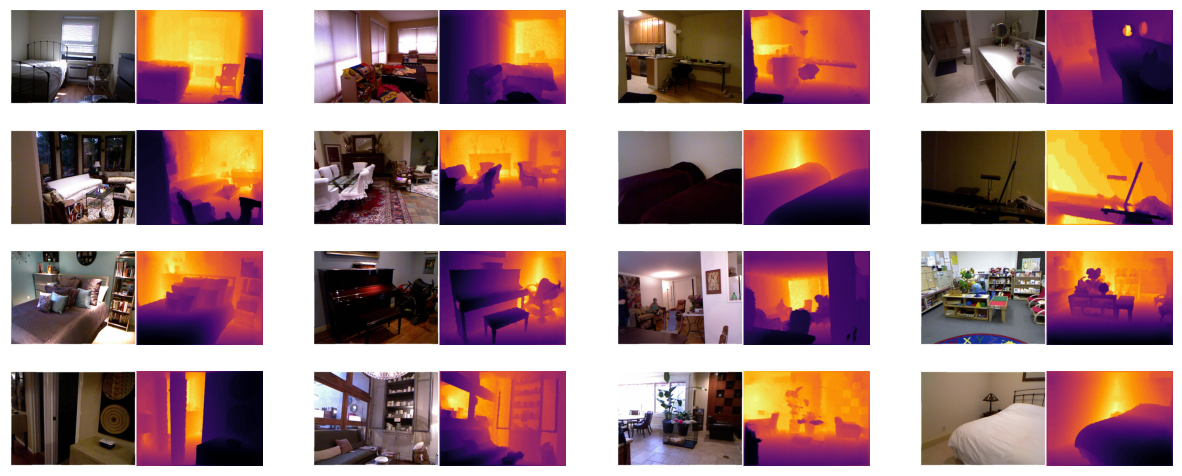

In [4]:
def colored_depthmap(depth, d_min=None, d_max=None, cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:, :, :3]  # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0, len(df), (16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx, 0]).convert('RGB')
    mask = Image.open(df.iloc[idx, 1]).convert('L')
    image_viz = merge_into_row(
        image, mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [5]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384, 384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224, 224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
        
    def open_im(self, p, gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        s = self.df.iloc[idx, :]
        im, dp = s[0], s[1]
        im, dp = self.open_im(im), self.open_im(dp, True)
        augs = self.tfms(image=im, mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

train_ds = Dataset(train_df, train_tfms)
val_ds = Dataset(val_df, valid_tfms)
test_ds = Dataset(test_df, valid_tfms)

num_workers = min(os.cpu_count(), len(train_ds))  # Use multiple workers
train_dl = DataLoader(train_ds, shuffle=True, batch_size=64, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=4, num_workers=num_workers, pin_memory=True)
# train_dl = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=64)
# val_dl = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=64)
# test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='timm-mobilenetv3_small_100',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1  # Outputting a single channel for depth map
        )
        
    def trainable_encoder(self, trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable
        
    def forward(self, x):
        return self.model(x)
    
    def _num_params(self):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])


class UnNormalize(Normalize):
    def __init__(self, *args, **kwargs):
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        new_mean = [-m / s for m, s in zip(mean, std)]
        new_std = [1 / s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets, n=4, figsize=(6, 2), title=''):
    plt.figure(figsize=figsize, dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i, idx in enumerate(np.random.randint(0, imgs.size(0), (n,))):
        ax = plt.subplot(r, c, i + 1)
        img, pred, gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img) * 255.
        img, pred, gt = img.permute(1, 2, 0).numpy(), pred.permute(1, 2, 0).numpy(), gt.permute(1, 2, 0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img, pred, gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title) != 0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [7]:
epochs = 10
freeze_epochs = 2
lr = 1e-3
logs = pd.DataFrame()
logs[['loss_train', 'loss_val', 'ssim_train', 'ssim_val', 'mse_train', 'mse_val']] = None

In [8]:
model = UNet().to(device)
model = nn.DataParallel(model, device_ids=[0, 1]) 
model.module.trainable_encoder(trainable=False)
loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))
scaler = GradScaler()
metrics = MetricCollection([
    SSIM(data_range=(0, 1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth
100%|██████████| 9.78M/9.78M [00:00<00:00, 113MB/s]
<ipython-input-8-2f2f652565c6>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training Epoch 1/10:   0%|          | 0/713 [00:00<?, ?it/s]<ipython-input-9-298381d24aa6>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Validation Epoch 1/10:   0%|          | 0/72 [00:00<?, ?it/s]<ipython-input-9-298381d24aa6>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Validation Epoch 1/10: 100%|██████████| 72/72 [00:41<00:00,  1.75it/s, loss=0.0141]


Epoch 1 Summary:
Train Loss: 0.0930, Val Loss: 0.0110
Train SSIM: 0.3651, Val SSIM: 0.5970
Train MSE: 0.0930, Val MSE: 0.0110



<ipython-input-9-298381d24aa6>:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


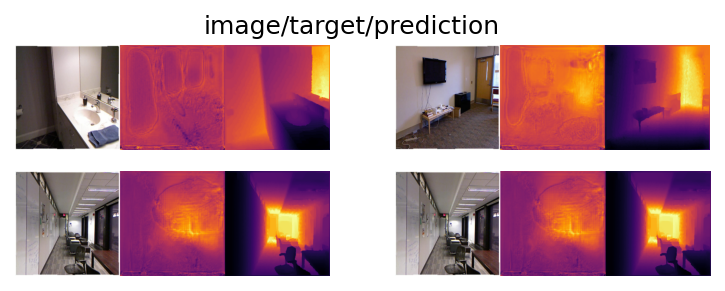

Training Epoch 2/10:   0%|          | 0/713 [00:00<?, ?it/s]<ipython-input-9-298381d24aa6>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Validation Epoch 3/10:   0%|          | 0/72 [00:00<?, ?it/s]<ipython-input-9-298381d24aa6>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Validation Epoch 3/10: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s, loss=0.0076]


Epoch 3 Summary:
Train Loss: 0.0105, Val Loss: 0.0058
Train SSIM: 0.8321, Val SSIM: 0.8451
Train MSE: 0.0105, Val MSE: 0.0058



<ipython-input-9-298381d24aa6>:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


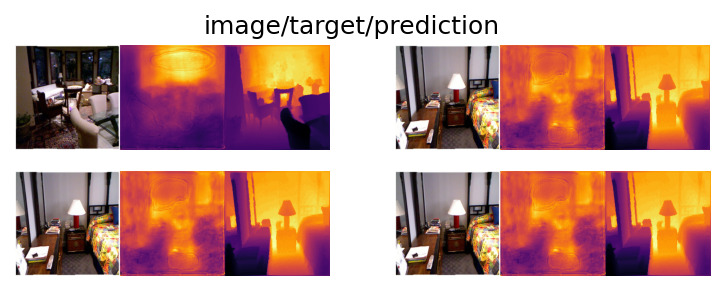

Training Epoch 4/10:   0%|          | 0/713 [00:00<?, ?it/s]<ipython-input-9-298381d24aa6>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Training Epoch 4/10:  49%|████▊     | 346/713 [05:16<05:29,  1.11it/s, loss=0.0093]

In [ ]:
best_ssim = -1e9
best_epoch = -1
logs = pd.DataFrame(columns=['loss_train', 'ssim_train', 'mse_train', 'loss_val', 'ssim_val', 'mse_val'])

for epoch in range(epochs):
    model.train()
    
    # Unfreeze encoder layers after certain epochs (if required)
    if epoch == freeze_epochs:
        model.module.trainable_encoder(trainable=True)
        print('Training encoder and decoder both')
    
    running_loss = 0.
    train_prog = tqdm(train_dl, desc=f"Training Epoch {epoch+1}/{epochs}")
    
    optim.zero_grad()  # Zero gradients once before the training loop
    for img, mask in train_prog:
        with autocast():  # Mixed precision
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            loss = loss_fn(preds, mask)
        
        # Scale the loss and call backward outside of autocast
        scaler.scale(loss).backward()
        
        # Unscale and clip gradients
        scaler.unscale_(optim)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        
        # Step the optimizer and scaler
        scaler.step(optim)
        scaler.update()
        
        # Step the scheduler
        sched.step()
        
        # Zero gradients for the next iteration
        optim.zero_grad()
        
        running_loss += loss.item()
        train_prog.set_postfix(loss=f"{loss.item():.4f}")
        train_metrics(preds, mask)
        
        del img, mask, preds, loss

    # Compute training metrics
    m = train_metrics.compute()
    train_ssim = m['StructuralSimilarityIndexMeasure'].cpu().item()
    train_mse = m['MeanSquaredError'].cpu().item()
    logs.loc[epoch, ['loss_train', 'ssim_train', 'mse_train']] = (running_loss/len(train_dl), train_ssim, train_mse)
    train_metrics.reset()

    # Validation phase
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        val_prog = tqdm(val_dl, desc=f"Validation Epoch {epoch+1}/{epochs}")
        for img, mask in val_prog:
            with autocast():  # Mixed precision
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds, mask)
                running_loss += loss.item()
                val_prog.set_postfix(loss=f"{loss.item():.4f}")
                val_metrics(preds, mask)
                
            del img, mask, preds, loss

        # Compute validation metrics
        m = val_metrics.compute()
        val_ssim = m['StructuralSimilarityIndexMeasure'].cpu().item()
        val_mse = m['MeanSquaredError'].cpu().item()
        logs.loc[epoch, ['loss_val', 'ssim_val', 'mse_val']] = (running_loss/len(val_dl), val_ssim, val_mse)
        val_metrics.reset()

    # Save best model based on SSIM
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd, '/kaggle/working/nyu-v2-depth-mobilenet-unetplusplus.pt')
    
    # Print summary only once per epoch
    epoch_summary = logs.loc[epoch, ['loss_train', 'loss_val', 'ssim_train', 'ssim_val', 'mse_train', 'mse_val']]
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {epoch_summary['loss_train']:.4f}, Val Loss: {epoch_summary['loss_val']:.4f}")
    print(f"Train SSIM: {epoch_summary['ssim_train']:.4f}, Val SSIM: {epoch_summary['ssim_val']:.4f}")
    print(f"Train MSE: {epoch_summary['mse_train']:.4f}, Val MSE: {epoch_summary['mse_val']:.4f}")
    
    # Visualize some predictions
    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )
        
    # Clear memory
    gc.collect()
    torch.cuda.empty_cache()

# Print final best model info
print("\nFinal Best Model:")
print(f"Best Epoch: {best_epoch+1}")
print(f"Best SSIM: {best_ssim:.4f}")

In [ ]:
best_sd = torch.load('/kaggle/working/nyu-v2-depth-mobilenet-unetplusplus.pt')
model.load_state_dict(best_sd)

all_imgs, all_preds, all_targets = [], [], []
with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl, desc="Testing", total=len(test_dl)):
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds)
            all_targets.append(mask)

test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()
title = f"SSIM: {m['StructuralSimilarityIndexMeasure'].cpu().item():.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"
plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10, 15),
    title=title
)

logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

logs['ssim_train'].plot()
logs['ssim_val'].plot()
plt.title('ssim : higher = better')
plt.legend()
plt.show()

In [ ]:
from IPython.display import FileLink
FileLink('nyu-v2-depth-mobilenet-unetplusplus.pt')